In [ ]:
%matplotlib inline

## Recursive Neural Networks

Recursive neural networks are extensions of recurrent neural networks for tree-structured data (refer e.g. to [Sperduti, 1997](http://www.ing.unisi.it/~monica/Paper/p20.pdf.gz), [Socher, 2013](http://www.aclweb.org/anthology/D13-1170)). However, to properly introduce recursive neural networks, we first need to talk about _trees_ for a moment.

Let $\Sigma$ be a finite set, which we call _alphabet_. A tree over $\Sigma$ is then recursively defined as $x(T_1, \ldots, T_m)$ where $x \in \Sigma$ and $T_1, \ldots, T_m$ is a (possibly empty) list of trees over $\Sigma$. We call $x$ the _label_ of the tree and $T_1, \ldots, T_m$ the _children_ of the tree. For example, if $\Sigma = \{ \neg, \vee, \wedge, x, y \}$ then the following are example trees $x()$, $y()$, $\neg(x())$, $\vee(x(), y())$, $x(\wedge(\neg(), y))$. Trees without children are called _leaves_. For simplicity, we typically omit the brackets for leaves. So the tree $x()$ can also be written as simply $x$.

Typically, considering all trees over an alphabet $\Sigma$ is too permissive. For example, if we want to express logical formulae as trees, then $x(\wedge(\neg(), y))$ is a tree over $\Sigma = \{ \neg, \vee, \wedge, x, y \}$, but it is not a valid logical formula. To prevent such invalid trees, we need to provide some additional structure. In this case, we do so by fixing the number of children for each symbol. If $\Sigma$ is an alphabet, an _arity function_ over $\Sigma$ is defined as a mapping $\alpha : \Sigma \to \mathbb{N}_0$. Accordingly, we call $\alpha(x)$ the _arity_ of $x \in \Sigma$ and we call the tuple $(\Sigma, \alpha)$ an _arity alphabet_. In our example, we could define $\alpha(\neg) = 1$, $\alpha(\wedge) = \alpha(\vee) = 2$, as well as $\alpha(x) = \alpha(y) = 0$.

We define a tree over an arity alphabet $(\Sigma, \alpha)$ as $x(T_1, \ldots, T_{\alpha(x)})$ where $x \in \Sigma$ and $T_1, \ldots, T_{\alpha(x)}$ are trees over $(\Sigma, \alpha)$. As you can easily check, our example arity alphabet now only permits valid logical formulae.

A recursive neural network is a means of mapping trees over an arity alphabet to real vectors. More precisely, a recursive neural network over an arity alphabet $(\Sigma, \alpha)$ is defined as a function $\mathcal{F}$ which maps any symbol $x \in \Sigma$ to a function $f_x : \underbrace{\mathbb{R}^k \times \ldots \times \mathbb{R}^k}_{\alpha(x) \text{ times}} \to \mathbb{R}^k$ for some $k \in \mathbb{N}$. Note that the functions for zero-arity symbols/leaves are constants. We can process a tree $x(T_1, \ldots, T_{\alpha(x)})$ via such a recursive neural network via the following recursive formula:
\begin{equation}
f\big(x(T_1, \ldots, T_{\alpha(x)})\big) := f_x\big(f(T_1), \ldots, f(T_{\alpha(x)})\big)
\end{equation}
Note that each $f_x$ is a feedforward neural network, hence the name _recursive neural network_.

### Formal Logic Example

In this notebook, we will learn a recursive neural network which learns the truth value of logical formulae from example trees with their truth value.

In [43]:
# For this exercise, we already provide data generation function (an 'oracle')
# which we can use
from recursive_oracle import generate_logical_tree

# let's have a look at an example tree and its truth value.
# Executing this cell multiple times will yield different trees.
x, y = generate_logical_tree()
print('the tree %s has truth value %g' % (str(x), y))

the tree and(x, y) has truth value 0


In [60]:
# Next, we set up our recursive neural network model
import torch

class RecursiveNet(torch.nn.Module):
    # As an input we expect:
    # dim - the dimensionality of the encoding space
    # arity_alphabet - a dictionary which maps symbols to their arity
    def __init__(self, dim, arity_alphabet):
        # In the constructor, we first call the constructor
        # for a general neural network module
        super(RecursiveNet, self).__init__()
        # Store the dimensionality
        self.dim = int(dim)
        # Store the arity alphabet
        self.arity_alphabet = arity_alphabet
        # We set up a dictionary of constants for the leaves
        self.constants = torch.nn.ParameterDict()
        # ... and a dictionary for sigmoid layers for the non-leaves
        self.layers = torch.nn.ModuleDict()
        # Then we initialize these for each symbol
        for symbol, arity in self.arity_alphabet.items():
            if(arity == 0):
                self.constants[symbol] = torch.nn.Parameter(torch.randn(self.dim))
            else:
                self.layers[symbol] = torch.nn.Linear(arity * self.dim, self.dim)
        # And we use a shared sigmoid for all layers
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, T):
        # this computes the forward pass for a single tree T
        # using the recursive computation formula

        # first, check if the tree has the right arity
        arity = self.arity_alphabet[T.label]
        if(len(T.children) != arity):
            raise ValueError('Expected %s children for a node with label %s but got %d children.' % (
                arity, T.label, len(T.children)))
        # Next, check if the tree is a leaf
        if(arity == 0):
            # if so, return the constant, filtered through the sigmoid
            return self.sigmoid(self.constants[T.label])
        # Otherwise we first need to compute the encodings for all
        # children and then encode the current tree
        child_encodings = []
        for child in T.children:
            child_encodings.append(self.forward(child))
        # concatenate all child encodings
        child_encodings = torch.cat(child_encodings)
        # compute the encoding for the current tree
        encoding = self.layers[T.label](child_encodings)
        encoding = self.sigmoid(encoding)
        return encoding

# Set up a recursive neural network for our example
k = 1
arity_alphabet = {'not' : 1, 'and' : 2, 'or' : 2, 'x' : 0, 'y' : 0}
model = RecursiveNet(k, arity_alphabet)

# Set up a loss function
loss_function = torch.nn.MSELoss()

# As optimizer, we use Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [61]:
# Starting from these ingredients we can optimize until
# the loss is low enough. You can also set the threshold lower
# to get even better results (if you have more time)
loss_threshold = 1E-2
learning_curve = []

minibatch_size = 50

while(not learning_curve or learning_curve[-1] > loss_threshold):
    # Don't forget to zero out the gradient
    optimizer.zero_grad()
    
    # In this case we will be working with minibatches because
    # the generated trees are so wildly different in size, thus
    # introducing very different errors
    loss_batch = 0
    for i in range(minibatch_size):
        # generate an example tree
        (x, y) = generate_logical_tree()
        # apply the model with the current parameters
        y_predicted = model(x)
        # compute the loss
        loss_object = loss_function(y, y_predicted)
        loss_batch += loss_object.item()
        # compute the gradient of the loss
        # Note that the gradient is accumulated over the
        # minibatch because we do not zero the gradient
        # within the batch
        loss_object.backward()

    # print the loss every 20 batches so that we see the progress
    # while learning happens
    learning_curve.append(loss_batch / minibatch_size)
    if(len(learning_curve) % 20 == 0):
        print('loss after {} batches: {}'.format(len(learning_curve), learning_curve[-1]))

    # compute a step of the optimizer based on the gradient
    optimizer.step()

loss after 20 batches: 0.22436552956700326
loss after 40 batches: 0.21382004849612712
loss after 60 batches: 0.21273231744766236
loss after 80 batches: 0.16791603922843934
loss after 100 batches: 0.18376320965588092
loss after 120 batches: 0.13934028193354606
loss after 140 batches: 0.13111647486686706
loss after 160 batches: 0.13234317345544697
loss after 180 batches: 0.11010331805795431
loss after 200 batches: 0.10762513080611825
loss after 220 batches: 0.11798544565215707
loss after 240 batches: 0.13493177929893135
loss after 260 batches: 0.1289773198403418
loss after 280 batches: 0.10246860431507229
loss after 300 batches: 0.07876131635159254
loss after 320 batches: 0.106330511495471
loss after 340 batches: 0.0711101636569947
loss after 360 batches: 0.07087125638499855
loss after 380 batches: 0.0738568608649075
loss after 400 batches: 0.07418032949324697
loss after 420 batches: 0.06471426470205188
loss after 440 batches: 0.0675542847532779
loss after 460 batches: 0.0705542367883026

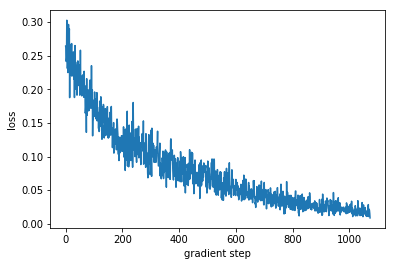

In [62]:
# plot the learning curve

import matplotlib.pyplot as plt

plt.plot(list(range(len(learning_curve))), learning_curve)
plt.xlabel('gradient step')
plt.ylabel('loss')
plt.show()

In [63]:
# Because our model has so few parameters, we can actually inspect
# the parameters in detail
for symbol, arity in arity_alphabet.items():
    if(arity > 0):
        w = model.layers[symbol].weight.data[0]
        b = model.layers[symbol].bias.data[0]
        print('weights for symbol \'%s\' = %s ; bias = %s' % (symbol, str(w), str(b)))
    else:
        print('encoding for symbol \'%s\' = %s' % (symbol, str(model.constants[symbol])))

weights for symbol 'not' = tensor([-5.1771]) ; bias = tensor(2.4468)
weights for symbol 'and' = tensor([2.3201, 2.3050]) ; bias = tensor(-3.4976)
weights for symbol 'or' = tensor([4.0584, 4.0702]) ; bias = tensor(-2.1756)
encoding for symbol 'x' = Parameter containing:
tensor([-2.9571], requires_grad=True)
encoding for symbol 'y' = Parameter containing:
tensor([3.8656], requires_grad=True)
